In [1]:
import os

import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 500)

from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.figure_factory as ff
%matplotlib inline

In [2]:
SubmissionWithCalibration = pd.read_csv('data/SubmissionWithCalibration.csv')

RealLabels = SubmissionWithCalibration.rlabel

XCeptionPredictions = pd.read_csv('data/submission_xception.csv')

ResNetPredictions = pd.read_csv('data/submission_resnext.csv')

NNPredictions = pd.DataFrame({"ResNetPredictions": ResNetPredictions.label,

                              "XCeptionPredictions": XCeptionPredictions.label})

NNPredictions

,ResNetPredictions,XCeptionPredictions
0,0.514175,0.953098
1,0.004443,0.095995
2,0.725788,0.843252
3,0.060911,0.041755
4,0.880215,0.789394
...,...,...
395,0.190556,0.080094
396,0.154894,0.022018
397,0.161928,0.369976
398,0.641655,0.852241


In [3]:
print("XCeption loss", log_loss(RealLabels, NNPredictions.XCeptionPredictions))

print("ResNet loss", log_loss(RealLabels, NNPredictions.ResNetPredictions))

XCeption loss 0.32565033410651995
ResNet loss 0.368694766137149


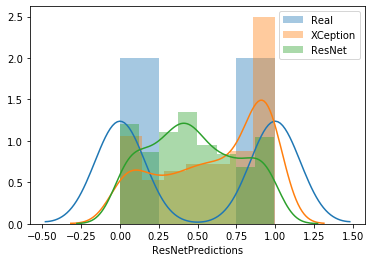

In [4]:
sns.distplot(RealLabels)

sns.distplot(NNPredictions.XCeptionPredictions)

sns.distplot(NNPredictions.ResNetPredictions)

plt.legend(['Real', 'XCeption', 'ResNet'])

In [5]:
Alphas = np.linspace(0, 1, 1001)

LogLoss = np.array([log_loss(RealLabels, np.dot(NNPredictions,
                                                    
                   [Alpha, 1 - Alpha])) for Alpha in Alphas])

BestAlpha = Alphas[LogLoss.argmin()]

BestLogLoss = LogLoss.min()

print(BestAlpha)

print(BestLogLoss)

0.245
0.32002707839550665


In [6]:
BestEnsembleByAlphaMethod = BestAlpha * ResNetPredictions.label + (1 - BestAlpha) * NNPredictions.XCeptionPredictions

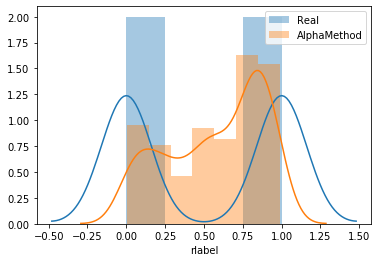

In [7]:
sns.distplot(RealLabels)

sns.distplot(BestEnsembleByAlphaMethod)

plt.legend(['Real', 'AlphaMethod'])

In [8]:
from sklearn.linear_model import LogisticRegression as LR

Model = LR(penalty = 'l2', dual = True, tol = 0.0001, C = 1, fit_intercept = True, intercept_scaling = 1.0, 
        
        class_weight = None, random_state = None)


Model.fit(np.array(BestEnsembleByAlphaMethod).reshape(-1, 1), RealLabels)

CalibratedPrediction = Model.predict_proba(np.array(BestEnsembleByAlphaMethod).reshape(-1, 1))[:, 1]

print(log_loss(RealLabels, CalibratedPrediction))

0.25451492012635796


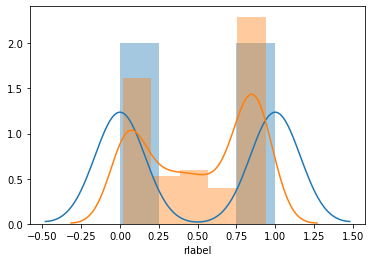

In [9]:
sns.distplot(RealLabels)

sns.distplot(CalibratedPrediction)

In [10]:
from sklearn.model_selection import GridSearchCV

grid = {"C": np.logspace(-3,3,66), "penalty": ["l1", "l2"]}
    
logreg = LR(random_state = 666)

logreg_cv = GridSearchCV(logreg, grid, cv = None)

logreg_cv.fit(np.array(BestEnsembleByAlphaMethod).reshape(-1, 1), RealLabels)

bests = logreg_cv.predict_proba(np.array(BestEnsembleByAlphaMethod).reshape(-1, 1))[:,1]

print("accuracy:",logreg_cv.best_score_)

print("tuned hyperparameters:",logreg_cv.best_params_)

print("log loss:", log_loss(RealLabels, bests))

accuracy: 0.9125
tuned hpyerparameters: {'C': 1.7012542798525891, 'penalty': 'l1'}
log loss: 0.17379827402032924


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



In [11]:
BestModel = LR(penalty = 'l1', C = 1.7, fit_intercept = True,
               
               intercept_scaling = 1.0, class_weight = None, random_state = None)

x = np.array(BestEnsembleByAlphaMethod).reshape(-1, 1)

BestModel.fit(x, RealLabels)

BestResult = BestModel.predict_proba(x)[:,1]

print("log loss:", log_loss(RealLabels, BestResult))

log loss: 0.17380233093861627


In [12]:
print(BestModel.coef_)

print(BestModel.intercept_)

[[14.89227925]]
[-9.39001786]


In [13]:
BestResult.mean()

0.5014705883040236